### **Plots for qualitative analysis - Joan**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd

In [23]:
def plot_heatmap(d, idx=0, model='base'):
    sample_jsds = d[idx]['jsds']
    tokens = d[idx]['words']
    layers = np.arange(1, get_num_layers(model) + 1)
    question = d[idx]['question']
    context = d[idx]['context']

    # Create a DataFrame from the sample JSDS data
    data = []
    for i in layers:
        layer_data = []
        for token in np.arange(0, len(tokens)):
            value = sample_jsds[token].get(i, -1) * 100000
            # Apply log transformation to avoid issues with zero values
            if value == -1 * 100000:
                layer_data.append(np.nan)  # Use NaN to handle "exited early" cases
            else:
                layer_data.append(np.log1p(value))  # log1p handles log(1 + x) to avoid log(0) issue
        data.append(layer_data)

    df = pd.DataFrame(data, index=[f"Layer {i}" for i in layers], columns=tokens)

    # Plot the heatmap
    num_tokens = len(tokens)
    fig_width = max(10, num_tokens)  # Adjust the denominator for desired width scaling

    plt.figure(figsize=(fig_width, 10))
    heatmap = sns.heatmap(df, annot=False, fmt=".4f", cmap="Purples", cbar=True, linewidths=0.5, linecolor='gray')

    # Add custom annotations
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            value = df.iat[i, j]
            if np.isnan(value):
                heatmap.text(j + 0.5, i + 0.5, '•', color='red', ha='center', va='center', fontsize=12, fontweight='bold')
            else:
                heatmap.text(j + 0.5, i + 0.5, f'{value:.4f}', color='black', ha='center', va='center', fontsize=8)

    # Customize the color bar to indicate log scale
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Log(1 + JSD Value)')  # Customize the color bar label

    # Customize the plot
    plt.title(f'Heatmap of JSDS Values for Each Token\nQuestion: {question}', fontsize=16)
    plt.xlabel('Tokens', fontsize=12)
    plt.ylabel('Layers', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()

# Example of a get_num_layers function, you should replace it with the actual implementation
def get_num_layers(model):
    if model == 'base':
        return 12
    elif model == 'large':
        return 24
    else:
        raise ValueError("Unsupported model type")

In [ ]:
def plot_average_exiting_layers(qa_pairs, average_exits, all_tokens, title='Average Exiting Layer per Token Position'):
    # Ensure the tokens list covers all positions in the average_exits dictionary
    positions = sorted(average_exits.keys())
    avg_layers = [average_exits[pos] for pos in positions]
    std_layers = [np.std(average_exits[pos]) for pos in positions]
    
    # Calculate frequency of each position
    position_counts = {pos: 0 for pos in positions}
    for qa in qa_pairs:
        jsds_list = qa['jsds']
        for token, layers in jsds_list.items():
            if token in position_counts:
                position_counts[token] += 1

    # Normalize frequencies for color mapping
    max_count = max(position_counts.values())
    normalized_counts = [position_counts[pos] / max_count for pos in positions]
    
    # Create color map
    norm = Normalize(vmin=0, vmax=1)
    cmap = plt.get_cmap('viridis')
    colors = [cmap(norm(count)) for count in normalized_counts]
    
    plt.figure(figsize=(len(positions) // 5, 10))
    sns.set(style="whitegrid")

    # Bar plot with error bars and color mapping
    bars = plt.bar(positions, avg_layers, yerr=std_layers, capsize=5, color=colors)
    min_exit_layer = 2
    plt.axhline(y=min_exit_layer, color='r', linestyle='--', linewidth=2, label=f'Minimum Exit Layer: {min_exit_layer}')

    # Add annotations
    for bar, layer in zip(bars, avg_layers):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{layer:.2f}', ha='center', va='bottom', fontsize=10)

    # Customize plot
    plt.xlabel('Token Position', fontsize=14)
    plt.ylabel('Average Exiting Layer', fontsize=14)
    plt.title(title + " - SQuAD", fontsize=18)
    plt.xticks(ticks=positions, labels=[all_tokens[pos] for pos in positions], rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    # Color bar for frequency
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=[0, 0.5, 1])
    cbar.set_label('Normalized Frequency', fontsize=14)
    cbar.set_ticklabels(['Low', 'Medium', 'High'])
    
    plt.savefig('average_exiting_layers.png', dpi=300, bbox_inches='tight')
    plt.savefig('average_exiting_layers.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_log(log_text, task='qa'):
    # Initialize the list to store all Q/A pairs
    qa_pairs = []

    # Split the log text into sections based on the '-END CONTEXT-' delimiter
    sections = log_text.strip().split('-END CONTEXT-')

    # Define regex patterns
    jsds_pattern = re.compile(r"JSDS:\s+{([^}]+)}")
    word_pattern = re.compile(r"Word:\s+(\S+)")
    
    if task == 'qa':
        question_pattern = re.compile(r"question:\s+(.*?)\s*context:")
        context_pattern = re.compile(r"context:\s+(.*)")
    elif task == 'translation':
        pass
    elif task == 'summarization':
        summarization_pattern = re.compile(r"summarize:\s+(.*)")
    else:
        raise ValueError(f"Invalid task: {task}")

    # Process each section separately
    for section in sections:
        section = section.strip()  # Clean up leading/trailing whitespace

        if not section:
            continue
        
        if task == 'qa': 
            # Extract question
            question_match = question_pattern.search(section)
            question = question_match.group(1).strip() if question_match else None

            # Extract context
            context_match = context_pattern.search(section)
            context = context_match.group(1).strip() if context_match else None
        elif task == 'summarization':
            summarization_match = summarization_pattern.search(section)
            question = None
            context = summarization_match.group(1).strip() if summarization_match else None
        elif task == 'translation':
            pass
        else:
            raise ValueError(f"Invalid task: {task}")

        # Extract all JSDS
        jsds_matches = jsds_pattern.findall(section)
        jsds_list = {}
        for i, jsds in enumerate(jsds_matches):
            layer_jsds = re.findall(r"(\d+):\s*tensor\(([\d\.e-]+),", jsds)
            jsds_dict = {int(layer): float(value) for layer, value in layer_jsds}
            jsds_list[i] = jsds_dict

        # Extract all words
        word_matches = word_pattern.findall(section)
        words = [match if match != "Token_id:" else ' ' for match in word_matches]  # Handle whitespace tokens

        # Add the Q/A pair to the list
        qa_pairs.append({
            'question': question,
            'context': context,
            'jsds': jsds_list,
            'words': words
        })

    return qa_pairs

def average_exiting_layer_per_position(qa_pairs):
    max_layers_per_position = {}

    for qa in qa_pairs:
        jsds_list = qa['jsds']
        for token, layers in jsds_list.items():
            max_layer = max(layers.keys()) if layers else 0
            if token not in max_layers_per_position:
                max_layers_per_position[token] = []
            max_layers_per_position[token].append(max_layer)
    
    average_exits = {token: np.mean(layers) for token, layers in max_layers_per_position.items()}
    return average_exits

def plot_average_exiting_layers(average_exits, tokens):
    positions = list(average_exits.keys())
    avg_layers = [average_exits[pos] for pos in positions]
    std_layers = [np.std(average_exits[pos]) for pos in positions]

    plt.figure(figsize=(14, 8))
    sns.set(style="whitegrid")

    # Bar plot with error bars
    bars = plt.bar(positions, avg_layers, yerr=std_layers, capsize=5, color=sns.color_palette("viridis", len(positions)))

    # Add annotations
    for bar, layer in zip(bars, avg_layers):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{layer:.2f}', ha='center', va='bottom', fontsize=10)

    # Customize plot
    plt.xlabel('Token Position', fontsize=14)
    plt.ylabel('Average Exiting Layer', fontsize=14)
    plt.title('Average Exiting Layer per Token Position', fontsize=18)
    plt.xticks(ticks=positions, labels=[tokens[pos] for pos in positions], rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [1]:
import re
import numpy as np

def parse_log(log_text, task='qa'):
    # Initialize the list to store all Q/A pairs
    qa_pairs = []

    # Split the log text into sections based on the '-END CONTEXT-' delimiter
    sections = log_text.strip().split('-END CONTEXT-')

    # Define regex patterns
    jsds_pattern = re.compile(r"JSDS:\s+{([^}]+)}")
    word_pattern = re.compile(r"Word:\s+(\S+)")
    
    if task == 'qa':
        question_pattern = re.compile(r"question:\s+(.*?)\s*context:")
        context_pattern = re.compile(r"context:\s+(.*)")
    elif task == 'translation':
        pass
    elif task == 'summarization':
        summarization_pattern = re.compile(r"summarize:\s+(.*)")
    else:
        raise ValueError(f"Invalid task: {task}")

    # Process each section separately
    for section in sections:
        section = section.strip()  # Clean up leading/trailing whitespace

        if not section:
            continue
        
        if task == 'qa': 
            # Extract question
            question_match = question_pattern.search(section)
            question = question_match.group(1).strip() if question_match else None

            # Extract context
            context_match = context_pattern.search(section)
            context = context_match.group(1).strip() if context_match else None
        elif task == 'summarization':
            summarization_match = summarization_pattern.search(section)
            question = None
            context = summarization_match.group(1).strip() if summarization_match else None
        elif task == 'translation':
            pass
        else:
            raise ValueError(f"Invalid task: {task}")

        # Extract all JSDS
        jsds_matches = jsds_pattern.findall(section)
        jsds_list = {}
        for i, jsds in enumerate(jsds_matches):
            layer_jsds = re.findall(r"(\d+):\s*tensor\(([\d\.e-]+),", jsds)
            jsds_dict = {int(layer): float(value) for layer, value in layer_jsds}
            jsds_list[i] = jsds_dict

        # Extract all words
        word_matches = word_pattern.findall(section)
        words = [match if match != "Token_id:" else ' ' for match in word_matches]  # Handle whitespace tokens

        # Add the Q/A pair to the list
        qa_pairs.append({
            'question': question,
            'context': context,
            'jsds': jsds_list,
            'words': words
        })

    return qa_pairs

def average_exiting_layer_per_position(qa_pairs):
    max_layers_per_position = {}

    for qa in qa_pairs:
        jsds_list = qa['jsds']
        for token, layers in jsds_list.items():
            max_layer = max(layers.keys()) if layers else 0
            if token not in max_layers_per_position:
                max_layers_per_position[token] = []
            max_layers_per_position[token].append(max_layer)
    
    average_exits = {token: np.mean(layers) for token, layers in max_layers_per_position.items()}
    return average_exits

# Example usage
log_text = """
question: What is the capital of France? context: The capital of France is Paris.
JSDS: {0: tensor(2.0, device='cuda:0'), 1: tensor(2.0, device='cuda:0'), 2: tensor(3.0, device='cuda:0')}
Word: What
Word: is
Word: the
Word: capital
Word: of
Word: France
Word: ?
-END CONTEXT-
"""

qa_pairs = parse_log(log_text, task='qa')
average_exits = average_exiting_layer_per_position(qa_pairs)
for token, avg_exit in average_exits.items():
    print(f"Token position {token}: Average exiting layer {avg_exit}")

Token position 0: Average exiting layer 2.0


In [2]:
qa_pairs

[{'question': 'What is the capital of France?',
  'context': 'The capital of France is Paris.',
  'jsds': {0: {0: 2.0, 1: 2.0, 2: 3.0}},
  'words': ['What', 'is', 'the', 'capital', 'of', 'France', '?']}]

In [4]:
qa_pairs2 = parse_log(log_text, task='qa')

In [5]:
qa_pairs2

[{'question': 'What is the capital of France?',
  'context': 'The capital of France is Paris.',
  'jsds': {0: {0: 2.0, 1: 2.0, 2: 3.0}},
  'words': ['What', 'is', 'the', 'capital', 'of', 'France', '?']}]

In [10]:
log_text = 'logs/samsum_bump.txt'
with open(log_text, 'r') as file:
    log_text = file.read()

log_text = log_text.split('** Evaluate **')[1]

In [20]:
qa_pairs = parse_log(log_text, task='summarization')

In [21]:
qa_pairs[1]

{'question': None,
 'context': 'Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids! Rob: I used to get one every year as a child! Loved them! Emma: Yeah, i remember! they were filled with chocolates! Lauren: they are different these days! much more sophisticated! Haha! Rob: yeah, they can be fabric/ wooden, shop bought/ homemade, filled with various stuff Emma: what do you fit inside? Lauren: small toys, Christmas decorations, creative stuff, hair bands & clips, stickers, pencils & rubbers, small puzzles, sweets Emma: WOW! That’s brill! X Lauren: i add one more very special thing as well- little notes asking my children to do something nice for someone else Rob: i like that! My sister adds notes asking her kids questions about christmas such as What did the 3 wise men bring? etc Lauren: i reckon it prepares them for Christmas Emma: and makes it more about traditions and being kind to other people Lauren: my children get very excited every time th

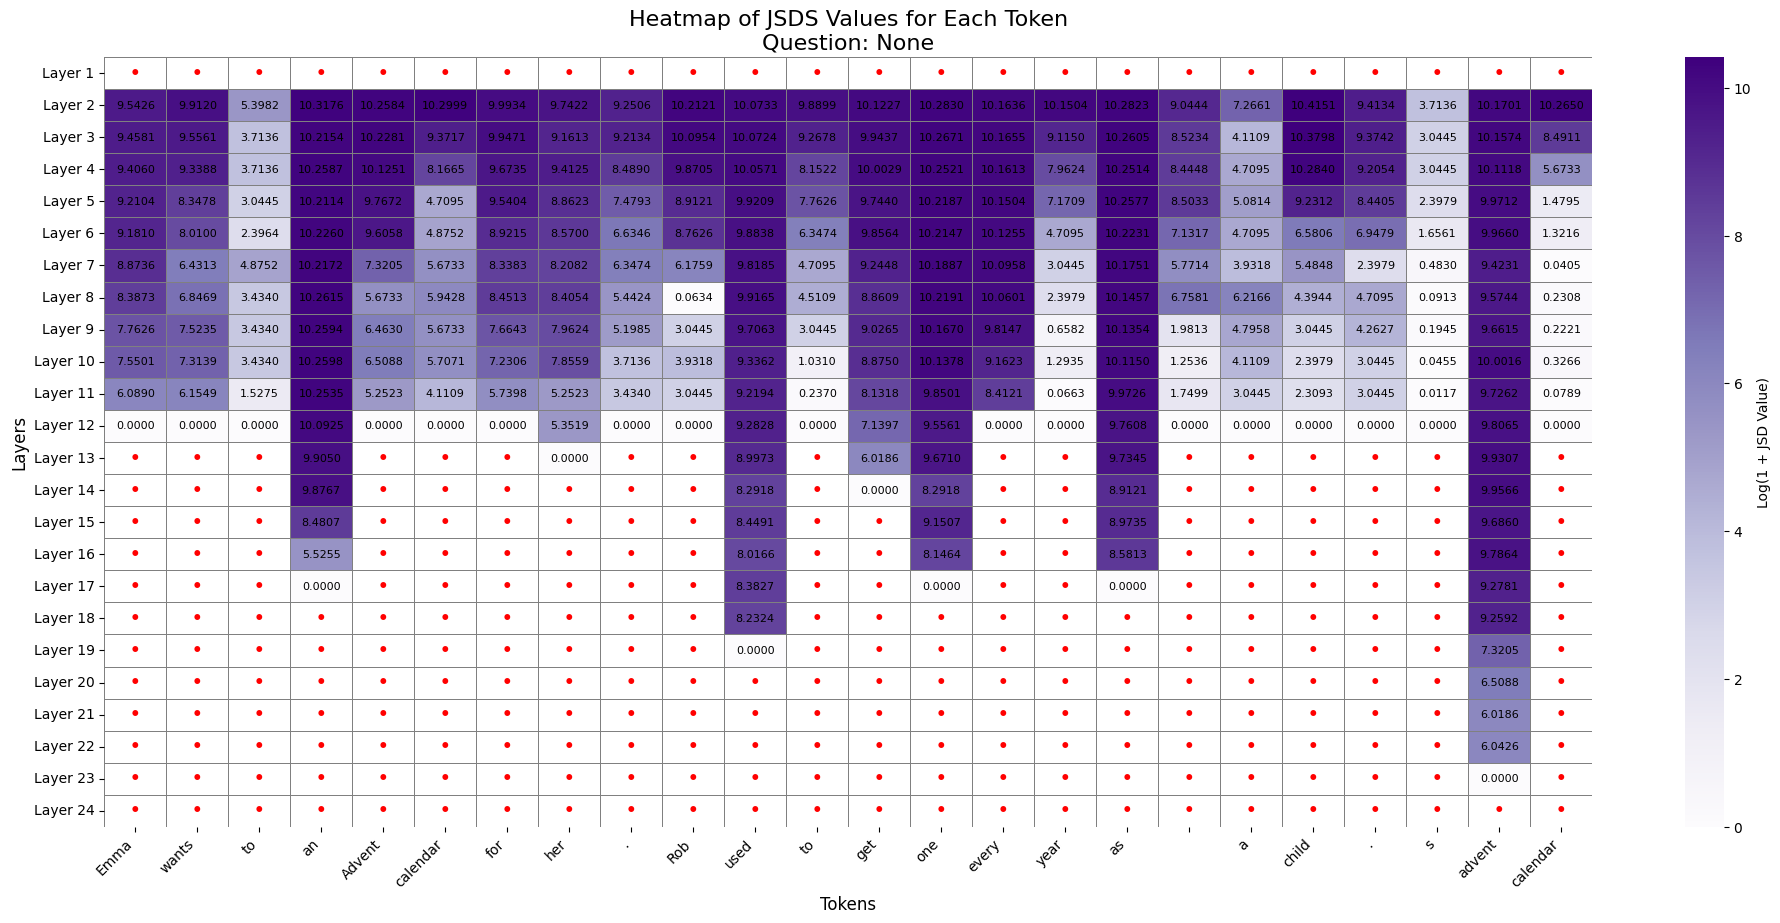

In [22]:
plot_heatmap(qa_pairs, idx=1, model='large')